# 🌲 Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model’s performance with RMSE and R² metrics.



In [8]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/pseudo_bulk/gdsc_cell_drug_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 13)


### 🔁 Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R².


In [10]:
os.makedirs("models_rf", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n🌲 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    joblib.dump(model, f"models_rf/rf_drug_{drug_id}.pkl")



🌲 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.2482 0.9109 0.8615 1.4143 1.2101] | Mean: 1.1290 ± 0.2104
  ➤ R²   (folds): [-0.0626  0.1062 -0.0786 -0.137  -0.0984] | Mean: -0.0541 ± 0.0839

🌲 Drug 3 | Samples: 356
  ➤ RMSE (folds): [2.1795 1.9488 2.3387 1.8444 2.3994] | Mean: 2.1422 ± 0.2155
  ➤ R²   (folds): [-0.0057 -0.2029 -0.1981 -0.1694 -0.2619] | Mean: -0.1676 ± 0.0864

🌲 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.7126 1.6692 1.6843 1.833  1.6883] | Mean: 1.7175 ± 0.0594
  ➤ R²   (folds): [-0.0769 -0.2338  0.0294 -0.1215 -0.066 ] | Mean: -0.0938 ± 0.0856

🌲 Drug 6 | Samples: 403
  ➤ RMSE (folds): [0.9167 1.1094 0.885  0.8636 0.8868] | Mean: 0.9323 ± 0.0901
  ➤ R²   (folds): [-0.1512 -0.1721 -0.0187 -0.1563 -0.0603] | Mean: -0.1117 ± 0.0608

🌲 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.5501 1.4869 1.3122 1.6016 1.5515] | Mean: 1.5005 ± 0.1009
  ➤ R²   (folds): [-0.0954 -0.1723  0.023  -0.0358 -0.075 ] | Mean: -0.0711 ± 0.0647

🌲 Drug 11 | Samples: 393
  ➤ RMSE (folds): [2.1304 2.1

In [11]:
results_df = pd.DataFrame(results)
results_df.to_csv("models_rf/model_performance_summary.csv", index=False)

print("📁 Saved to models_rf/model_performance_summary.csv")
results_df.head()


📁 Saved to models_rf/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.129010,0.210381,-0.054074,0.083923
1,3,356,2.142177,0.215503,-0.167609,0.086366
2,5,394,1.717471,0.059408,-0.093762,0.085590
3,6,403,0.932299,0.090136,-0.111737,0.060824
4,9,396,1.500464,0.100924,-0.071099,0.064727


### 📊 Distribution of RF Model Performance
We now visualize the RMSE and R² scores to analyze how well the RF models performed across all drugs.


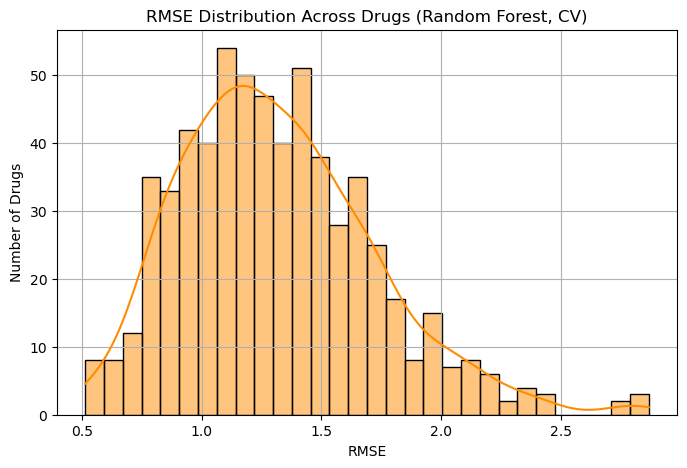

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

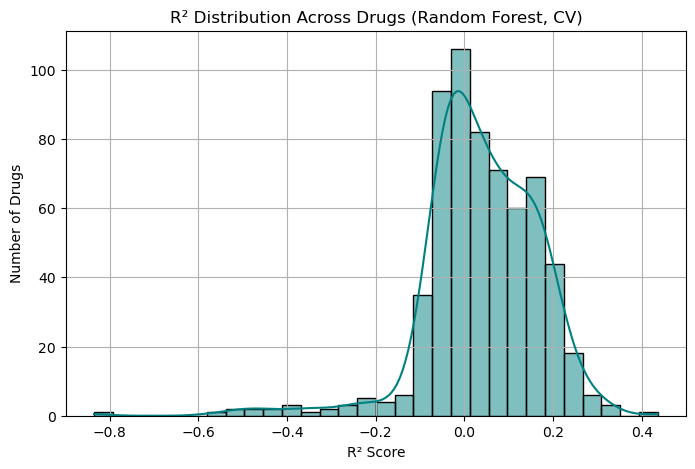

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()